In [ ]:
# Dataset Analysis: master_raw.csv & model_data.csv

import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("__file__"), "..")))

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

raw = pd.read_csv("../data/raw/master_raw.csv")
processed = pd.read_csv("../data/processed/model_data.csv")

print("=" * 60)
print("MASTER_RAW (data/raw/master_raw.csv)")
print("=" * 60)
print(f"Shape: {raw.shape[0]:,} rows x {raw.shape[1]} columns")
print(f"Columns: {list(raw.columns)}")
print(f"Date range: {raw['date'].min()} → {raw['date'].max()}")
print(f"Unique countries: {raw['country'].nunique()}")
print(f"Unique source_files: {raw['source_file'].nunique()}")
print(f"Nulls: {raw.isnull().sum().sum()}")
print()
print("=" * 60)
print("MODEL_DATA (data/processed/model_data.csv)")
print("=" * 60)
print(f"Shape: {processed.shape[0]:,} rows x {processed.shape[1]} columns")
print(f"Date range: {processed['month_year'].min()} → {processed['month_year'].max()}")
print(f"Unique admin1 regions: {processed['matched_admin1_id'].nunique()}")
print(f"Nulls: {processed.isnull().sum().sum():,} / {processed.size:,} ({processed.isnull().sum().sum()/processed.size*100:.2f}%)")
print(f"\nColumns:\n{list(processed.columns)}")

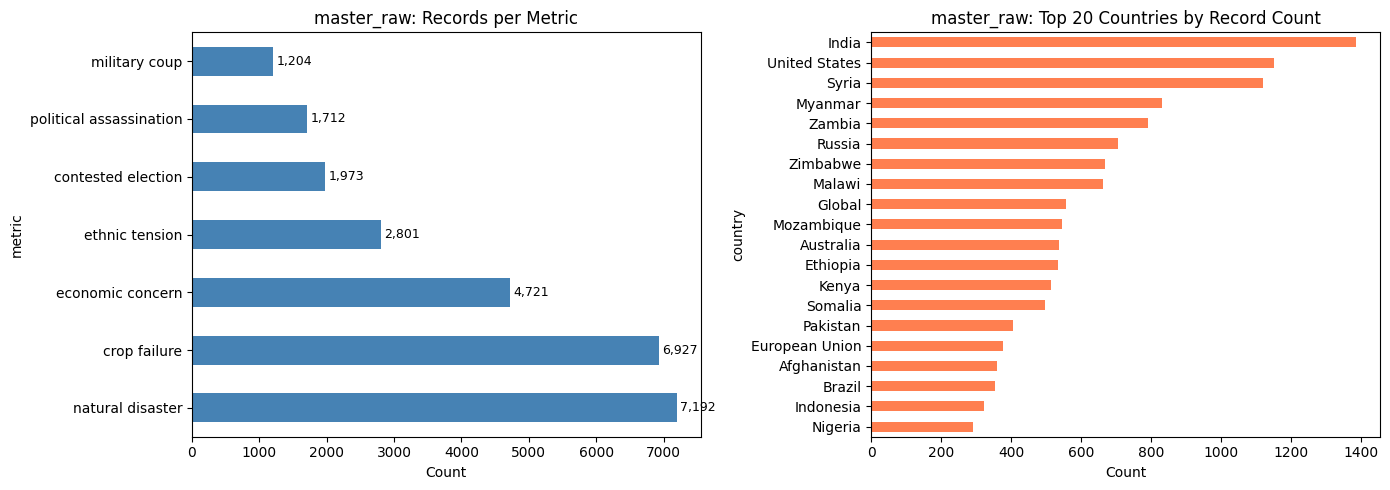

In [6]:
# --- MASTER_RAW: Metric distribution ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Metric counts
metric_counts = raw["metric"].value_counts()
metric_counts.plot.barh(ax=axes[0], color="steelblue")
axes[0].set_title("master_raw: Records per Metric")
axes[0].set_xlabel("Count")
for i, v in enumerate(metric_counts.values):
    axes[0].text(v + 50, i, f"{v:,}", va="center", fontsize=9)

# Top 20 countries by record count
top_countries = raw["country"].value_counts().head(20)
top_countries.plot.barh(ax=axes[1], color="coral")
axes[1].set_title("master_raw: Top 20 Countries by Record Count")
axes[1].set_xlabel("Count")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

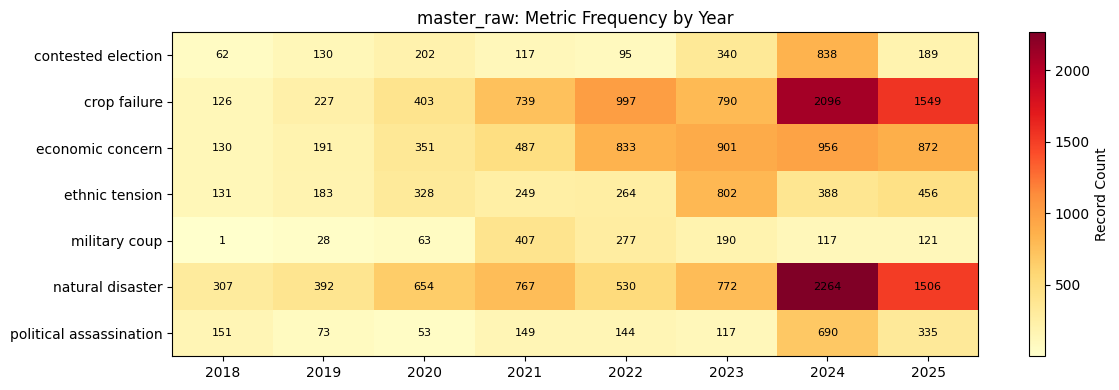

In [7]:
# --- MASTER_RAW: Metric over time heatmap ---
raw["parsed_date"] = pd.to_datetime(raw["date"], format="%m-%Y")
raw["year"] = raw["parsed_date"].dt.year

pivot = raw.groupby(["year", "metric"]).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(12, 4))
im = ax.imshow(pivot.T.values, aspect="auto", cmap="YlOrRd")
ax.set_xticks(range(len(pivot.index)))
ax.set_xticklabels(pivot.index.astype(int))
ax.set_yticks(range(len(pivot.columns)))
ax.set_yticklabels(pivot.columns)
ax.set_title("master_raw: Metric Frequency by Year")
plt.colorbar(im, ax=ax, label="Record Count")

# Annotate cells
for i in range(pivot.T.shape[0]):
    for j in range(pivot.T.shape[1]):
        ax.text(j, i, f"{pivot.T.values[i, j]}", ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.show()

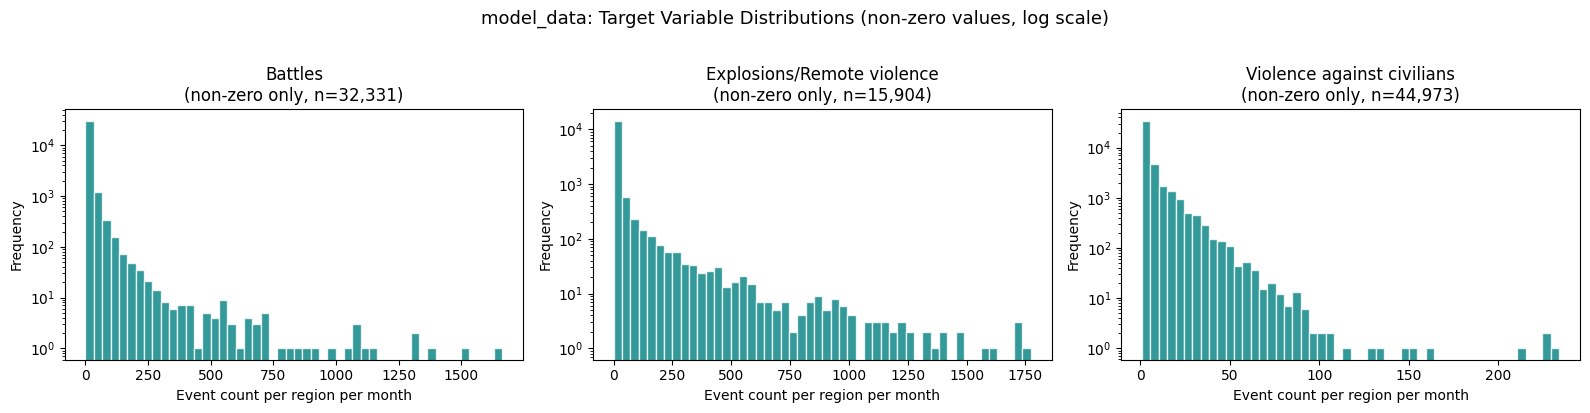

Target variable summary (per region per month):

  Battles:
    Total rows: 278,820  |  Zero: 246,489 (88.4%)  |  Non-zero: 32,331
    Mean: 1.236  |  Non-zero mean: 10.66  |  Median: 0  |  Max: 1664

  Explosions/Remote violence:
    Total rows: 278,820  |  Zero: 262,916 (94.3%)  |  Non-zero: 15,904
    Mean: 1.412  |  Non-zero mean: 24.76  |  Median: 0  |  Max: 1773

  Violence against civilians:
    Total rows: 278,820  |  Zero: 233,847 (83.9%)  |  Non-zero: 44,973
    Mean: 0.853  |  Non-zero mean: 5.29  |  Median: 0  |  Max: 234


In [20]:
# --- MODEL_DATA: Target variable distributions (per region per month) ---
targets = ["Battles", "Explosions/Remote violence", "Violence against civilians"]

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for i, col in enumerate(targets):
    nonzero = processed[col][processed[col] > 0]
    axes[i].hist(nonzero, bins=50, color="teal", edgecolor="white", alpha=0.8)
    axes[i].set_title(f"{col}\n(non-zero only, n={len(nonzero):,})")
    axes[i].set_xlabel("Event count per region per month")
    axes[i].set_ylabel("Frequency")
    axes[i].set_yscale("log")

plt.suptitle("model_data: Target Variable Distributions (non-zero values, log scale)", y=1.02, fontsize=13)
plt.tight_layout()
plt.show()

print("Target variable summary (per region per month):")
for col in targets:
    s = processed[col]
    nz = s[s > 0]
    print(f"\n  {col}:")
    print(f"    Total rows: {len(s):,}  |  Zero: {(s==0).sum():,} ({(s==0).mean()*100:.1f}%)  |  Non-zero: {len(nz):,}")
    print(f"    Mean: {s.mean():.3f}  |  Non-zero mean: {nz.mean():.2f}  |  Median: {s.median():.0f}  |  Max: {s.max():.0f}")

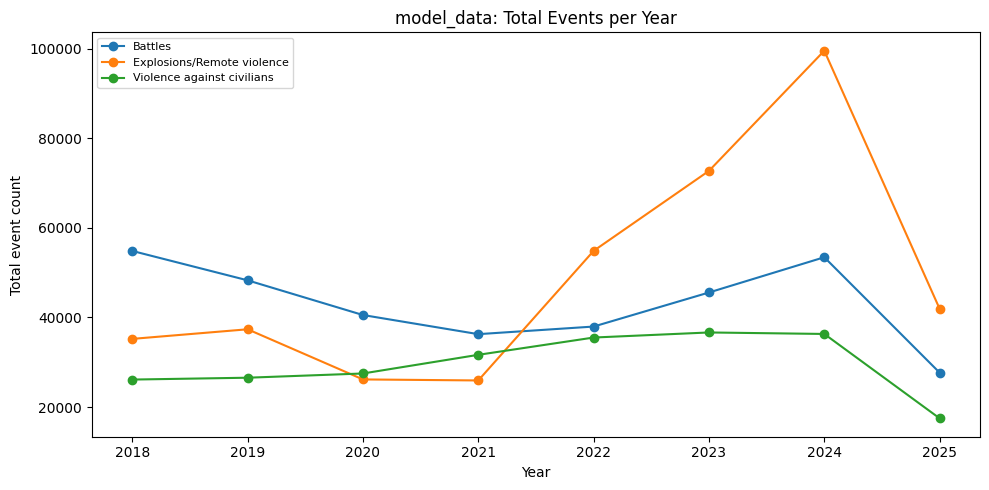

In [19]:
# --- MODEL_DATA: Total events per year ---
processed["month_year_dt"] = pd.to_datetime(processed["month_year"])
processed["yr"] = processed["month_year_dt"].dt.year
yearly = processed.groupby("yr")[targets].sum()

fig, ax = plt.subplots(figsize=(10, 5))
yearly.plot(ax=ax, marker="o")
ax.set_title("model_data: Total Events per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Total event count")
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

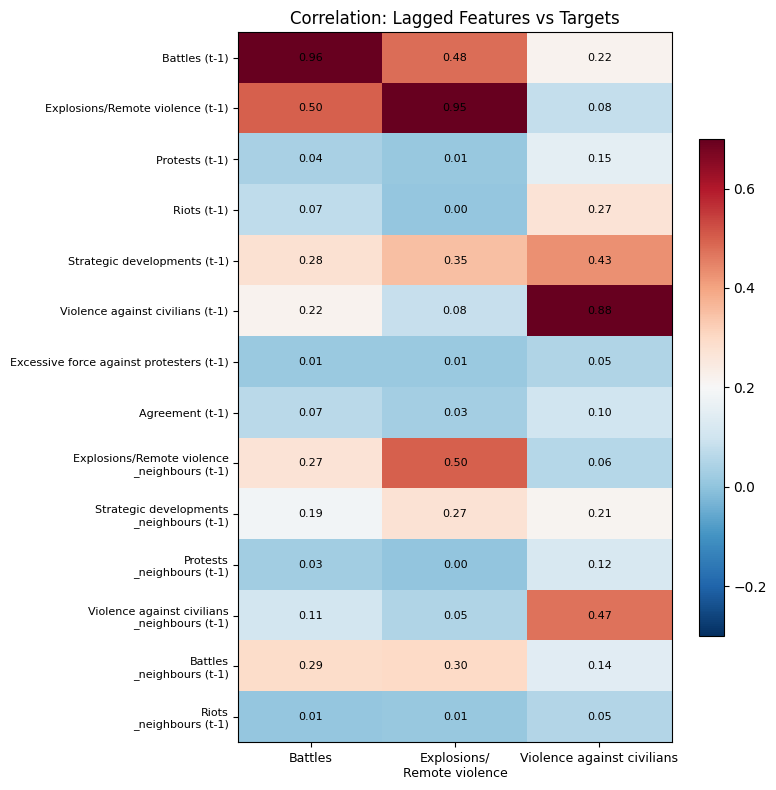

KEY OBSERVATIONS

MASTER_RAW (scraped conflict indicators):
  - 26,530 records from 236 country source files, covering 01-2018 to 12-2024
  - 7 metric types: natural disaster, crop failure, economic concern,
    ethnic tension, contested election, political assassination, military coup
  - 399 unique 'country' entries (includes regions, US states → noisy)
  - No nulls — this is a flat, fully populated scraping output

MODEL_DATA (processed panel for forecasting):
  - 278,820 rows = 3,097 admin1 regions × ~90 months (Jan 2018 – Jun 2025)
  - 36 columns: 8 lagged event features, 6 neighbour spillover features,
    14 time/seasonal dummies, importance_weight, and 3 target variables
  - Targets are heavily zero-inflated (83-94% zeros), right-skewed
  - Only 0.4% nulls — concentrated in lagged features for the first month
  - NOTE: master_raw metrics are NOT yet integrated as features in model_data
    → potential opportunity to use them as additional predictors



In [10]:
# --- MODEL_DATA: Correlation between lagged features and targets ---
lag_feats = [c for c in processed.columns if "(t-1)" in c]
corr_data = processed[lag_feats + targets].corr().loc[lag_feats, targets]

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(corr_data.values, cmap="RdBu_r", vmin=-0.3, vmax=0.7, aspect="auto")
ax.set_xticks(range(len(targets)))
ax.set_xticklabels([t.replace("/", "/\n") for t in targets], fontsize=9)
ax.set_yticks(range(len(lag_feats)))
ax.set_yticklabels([f.replace("_neighbours", "\n_neighbours") for f in lag_feats], fontsize=8)
ax.set_title("Correlation: Lagged Features vs Targets")
plt.colorbar(im, ax=ax, shrink=0.7)

for i in range(len(lag_feats)):
    for j in range(len(targets)):
        ax.text(j, i, f"{corr_data.values[i, j]:.2f}", ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.show()

# Key observations
print("=" * 60)
print("KEY OBSERVATIONS")
print("=" * 60)
print("""
MASTER_RAW (scraped conflict indicators):
  - 26,530 records from 236 country source files, covering 01-2018 to 12-2024
  - 7 metric types: natural disaster, crop failure, economic concern,
    ethnic tension, contested election, political assassination, military coup
  - 399 unique 'country' entries (includes regions, US states → noisy)
  - No nulls — this is a flat, fully populated scraping output

MODEL_DATA (processed panel for forecasting):
  - 278,820 rows = 3,097 admin1 regions × ~90 months (Jan 2018 – Jun 2025)
  - 36 columns: 8 lagged event features, 6 neighbour spillover features,
    14 time/seasonal dummies, importance_weight, and 3 target variables
  - Targets are heavily zero-inflated (83-94% zeros), right-skewed
  - Only 0.4% nulls — concentrated in lagged features for the first month
  - NOTE: master_raw metrics are NOT yet integrated as features in model_data
    → potential opportunity to use them as additional predictors
""")

---
# Model Forecasting: Top 20 Conflict Regions

In [ ]:
from utils.preprocessing import prepare_data_pipeline, filter_admin1_data
from models.simple_model import train_and_evaluate_model
from config import settings

# Load data once
model_data = prepare_data_pipeline(clean_data=False)

# Top 20 regions by total conflict events
top_20_regions = [
    "UKR - Donetsk", "UKR - Kharkiv", "UKR - Sumy", "SYR - Idlib",
    "PSX - Gaza", "UKR - Kherson", "BRA - Rio de Janeiro", "SYR - Aleppo",
    "UKR - Zaporizhzhia", "UKR - Luhansk", "RUS - Belgorod", "IRQ - Duhok",
    "SYR - Hama", "YEM - Al Hudaydah", "MMR - Sagaing", "SYR - Deir ez-Zor",
    "LBN - Nabatiye", "COD - Nord-Kivu", "PSX - West Bank", "YEM - Sa'dah"
]

events = ["Battles", "Explosions/Remote violence", "Violence against civilians"]

print(f"Will run {len(top_20_regions)} regions x {len(events)} events = {len(top_20_regions) * len(events)} model runs")

In [12]:
# Run all models and collect metrics
results = []

for region in top_20_regions:
    region_data = filter_admin1_data(model_data, region)
    for event in events:
        try:
            mae, mape = train_and_evaluate_model(region_data, event, region_name=region)
            results.append({"Region": region, "Event": event, "MAE": mae, "MAPE (%)": mape})
        except Exception as e:
            print(f"  ERROR: {region} / {event} → {e}")
            results.append({"Region": region, "Event": event, "MAE": None, "MAPE (%)": None})

results_df = pd.DataFrame(results)
print(f"\nCompleted {len(results)} model runs.")


Forecast Results for Battles in UKR - Donetsk
MAE: 263.47
MAPE: 18.50%

Forecast Results for Explosions/Remote violence in UKR - Donetsk
MAE: 63.45
MAPE: 13.65%

Forecast Results for Violence against civilians in UKR - Donetsk
MAE: 2.81
MAPE: 144.42%

Forecast Results for Battles in UKR - Kharkiv
MAE: 31.12
MAPE: 10.37%

Forecast Results for Explosions/Remote violence in UKR - Kharkiv
MAE: 25.58
MAPE: 12.40%

Forecast Results for Violence against civilians in UKR - Kharkiv
MAE: 1.22
MAPE: 95.50%

Forecast Results for Battles in UKR - Sumy
MAE: 40.36
MAPE: 83.48%

Forecast Results for Explosions/Remote violence in UKR - Sumy
MAE: 210.23
MAPE: 18.13%

Forecast Results for Violence against civilians in UKR - Sumy
MAE: 1.51
MAPE: nan%

Forecast Results for Battles in SYR - Idlib
MAE: 12.34
MAPE: 946.58%

Forecast Results for Explosions/Remote violence in SYR - Idlib
MAE: 135.75
MAPE: 982.72%

Forecast Results for Violence against civilians in SYR - Idlib
MAE: 5.73
MAPE: 305.66%

Forecast 

In [13]:
# --- Results summary table ---
print("=" * 70)
print("FORECAST METRICS SUMMARY (Top 20 Regions x 3 Event Types)")
print("=" * 70)

# Pivot for cleaner display
for event in events:
    subset = results_df[results_df["Event"] == event][["Region", "MAE", "MAPE (%)"]].set_index("Region")
    subset.columns = [f"MAE", f"MAPE (%)"]
    print(f"\n{'─' * 50}")
    print(f"  {event}")
    print(f"{'─' * 50}")
    print(subset.to_string())

# Overall stats
print(f"\n{'=' * 70}")
print("AGGREGATE STATISTICS")
print(f"{'=' * 70}")
valid = results_df.dropna()
for event in events:
    ev = valid[valid["Event"] == event]
    print(f"\n  {event}:")
    print(f"    Avg MAE: {ev['MAE'].mean():.2f}  |  Median MAE: {ev['MAE'].median():.2f}  |  Best: {ev.loc[ev['MAE'].idxmin(), 'Region']} ({ev['MAE'].min():.2f})")
    print(f"    Avg MAPE: {ev['MAPE (%)'].mean():.1f}%  |  Median MAPE: {ev['MAPE (%)'].median():.1f}%")

FORECAST METRICS SUMMARY (Top 20 Regions x 3 Event Types)

──────────────────────────────────────────────────
  Battles
──────────────────────────────────────────────────
                             MAE     MAPE (%)
Region                                       
UKR - Donetsk         263.473333    18.502779
UKR - Kharkiv          31.120000    10.373070
UKR - Sumy             40.358333    83.481179
SYR - Idlib            12.343333   946.583333
PSX - Gaza             40.373333  1095.970083
UKR - Kherson          11.980000    18.831155
BRA - Rio de Janeiro   18.726667    10.793022
SYR - Aleppo           52.935000   438.914678
UKR - Zaporizhzhia     39.981667    36.054719
UKR - Luhansk          33.025000    63.058455
RUS - Belgorod         12.581667    78.334169
IRQ - Duhok            14.763333    71.057308
SYR - Hama             35.610000  1569.120000
YEM - Al Hudaydah       5.903333   769.000000
MMR - Sagaing          20.176667    59.764372
SYR - Deir ez-Zor      31.975000   118.254050
L

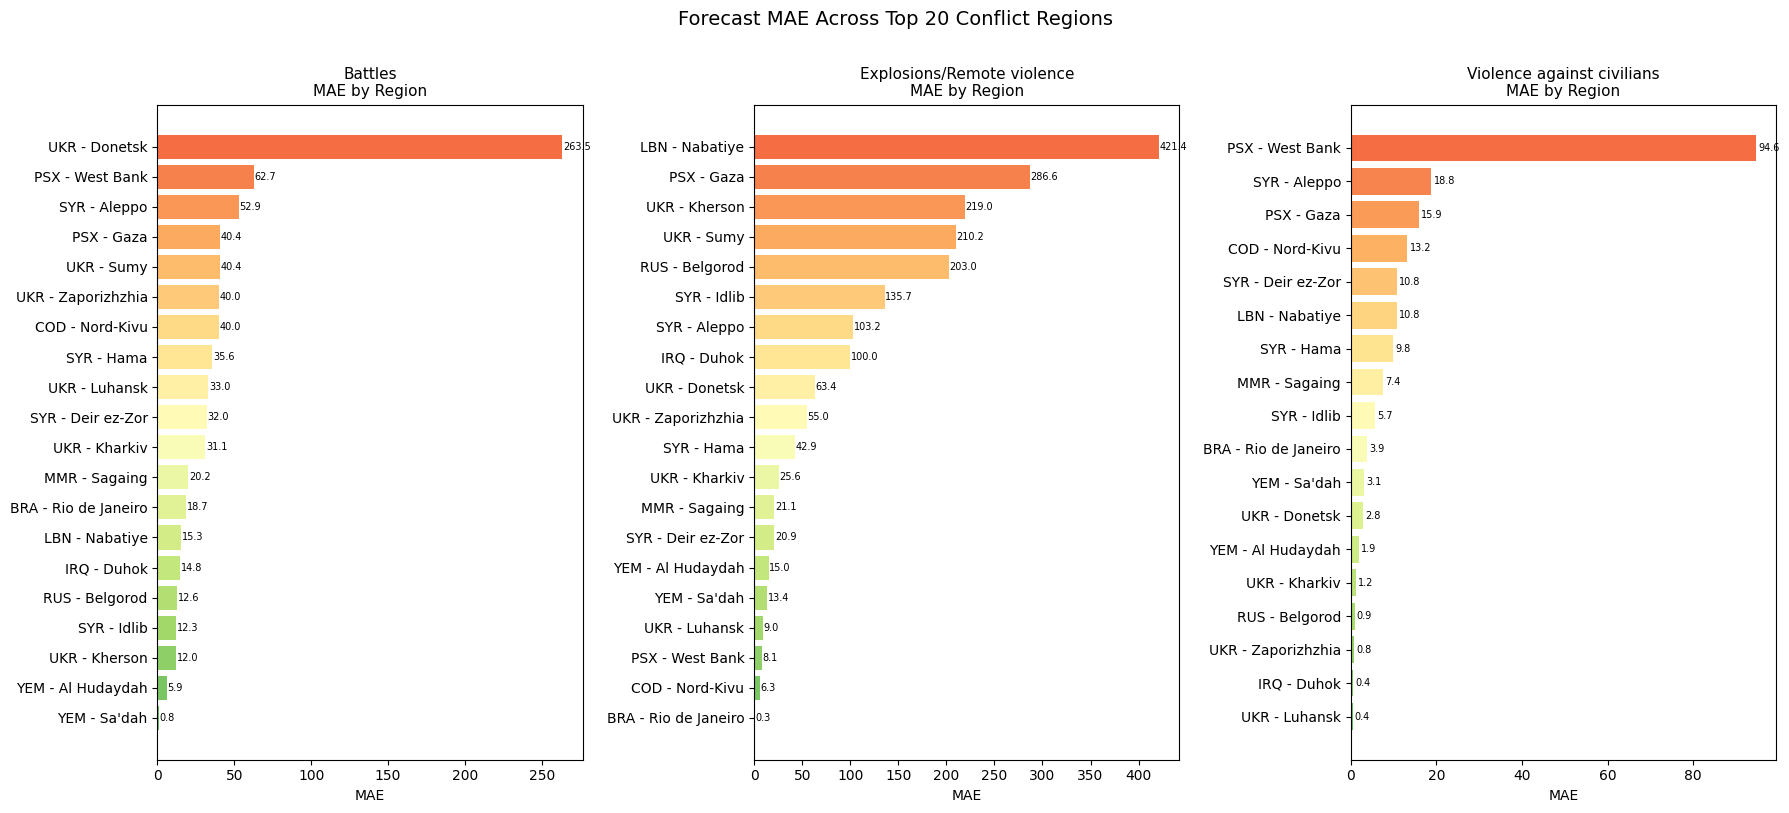

In [14]:
# --- Visual comparison: MAE by region and event type ---
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

for i, event in enumerate(events):
    subset = results_df[results_df["Event"] == event].dropna().sort_values("MAE", ascending=True)
    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(subset)))
    axes[i].barh(subset["Region"], subset["MAE"], color=colors)
    axes[i].set_title(f"{event}\nMAE by Region", fontsize=11)
    axes[i].set_xlabel("MAE")
    for j, (_, row) in enumerate(subset.iterrows()):
        axes[i].text(row["MAE"] + 0.5, j, f"{row['MAE']:.1f}", va="center", fontsize=7)

plt.suptitle("Forecast MAE Across Top 20 Conflict Regions", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

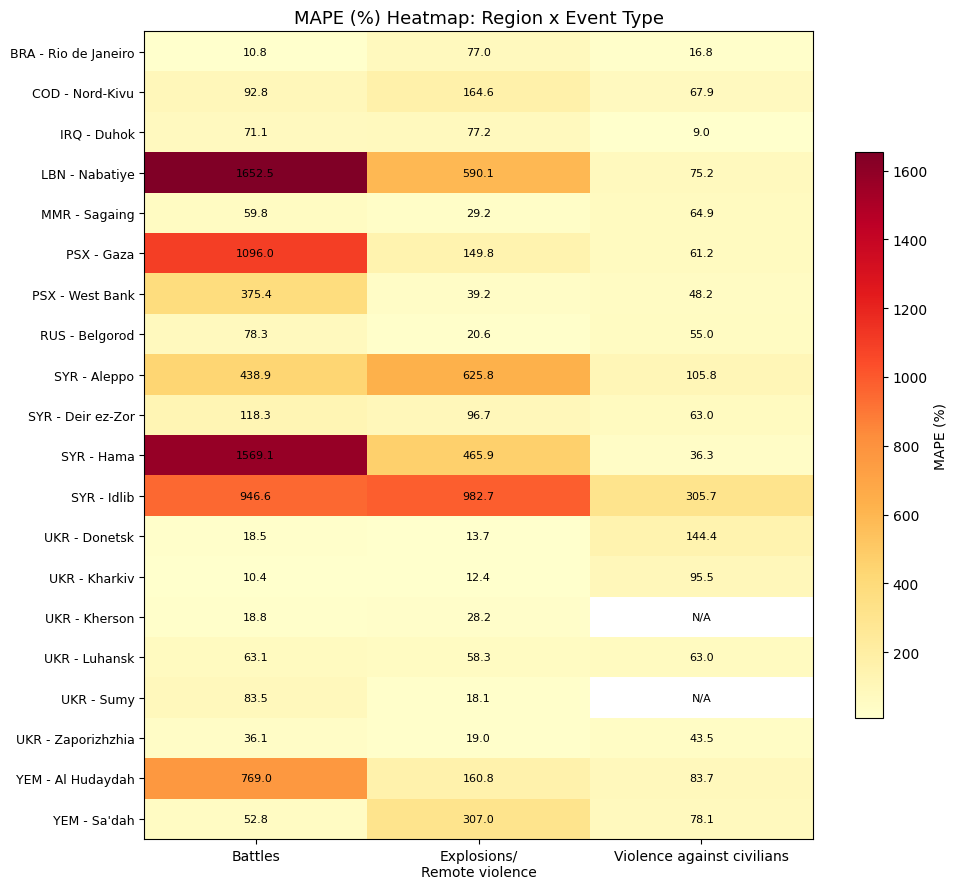

In [15]:
# --- MAPE heatmap: Region x Event ---
heatmap_data = results_df.pivot(index="Region", columns="Event", values="MAPE (%)")
heatmap_data = heatmap_data[events]  # consistent order

fig, ax = plt.subplots(figsize=(10, 9))
im = ax.imshow(heatmap_data.values, cmap="YlOrRd", aspect="auto")
ax.set_xticks(range(len(events)))
ax.set_xticklabels([e.replace("/", "/\n") for e in events], fontsize=10)
ax.set_yticks(range(len(heatmap_data.index)))
ax.set_yticklabels(heatmap_data.index, fontsize=9)
ax.set_title("MAPE (%) Heatmap: Region x Event Type", fontsize=13)
plt.colorbar(im, ax=ax, label="MAPE (%)", shrink=0.7)

for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        val = heatmap_data.values[i, j]
        text = f"{val:.1f}" if pd.notna(val) else "N/A"
        ax.text(j, i, text, ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.show()